<a href="https://colab.research.google.com/github/AhamedSulaiman/Fake-news/blob/main/BigMart_Sales_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
train = pd.read_csv("train_kOBLwZA.csv")
test = pd.read_csv("test_t02dQwI.csv")

In [ ]:
print(train.shape, test.shape)
print(train.head())
print(train.info())
print(train.describe())

(8523, 12) (5681, 11)
  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Med

In [ ]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace=True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace=True)

train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)
test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0], inplace=True)

train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

/tmp/ipython-input-2600999294.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace=True)
/tmp/ipython-input-2600999294.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [ ]:
train['Outlet_Age'] = 2025 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2025 - test['Outlet_Establishment_Year']

cat_cols = ['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']
le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [ ]:
Q1 = train['Item_Outlet_Sales'].quantile(0.25)
Q3 = train['Item_Outlet_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers instead of dropping
train['Item_Outlet_Sales'] = np.where(
    train['Item_Outlet_Sales'] > upper_bound,
    upper_bound,
    np.where(train['Item_Outlet_Sales'] < lower_bound, lower_bound, train['Item_Outlet_Sales'])
)

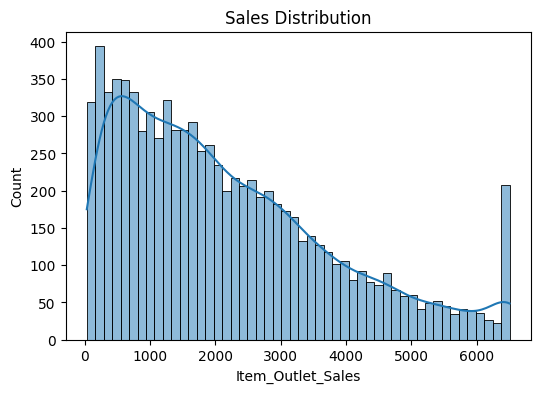

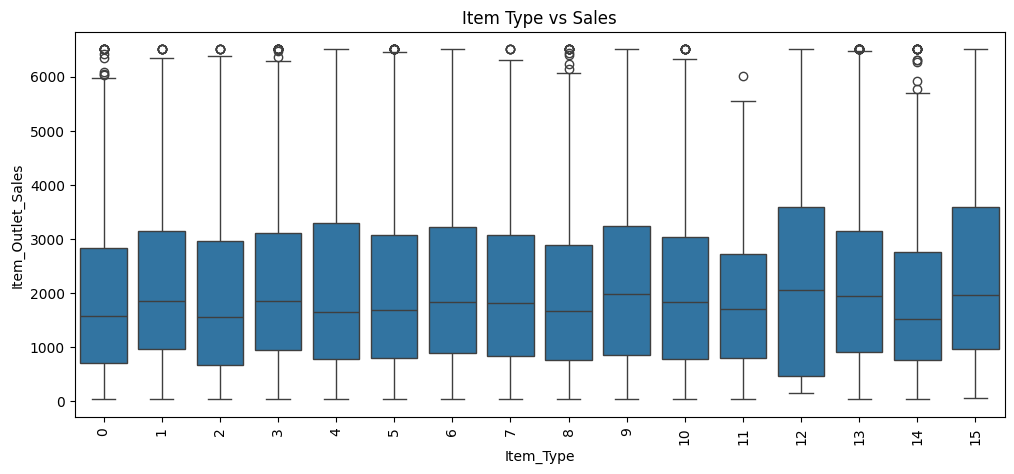

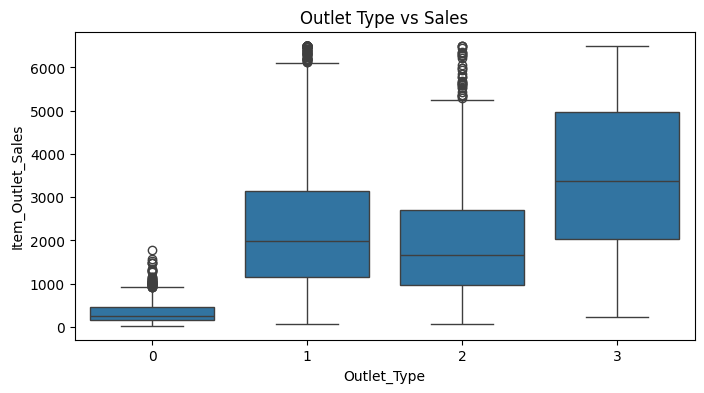

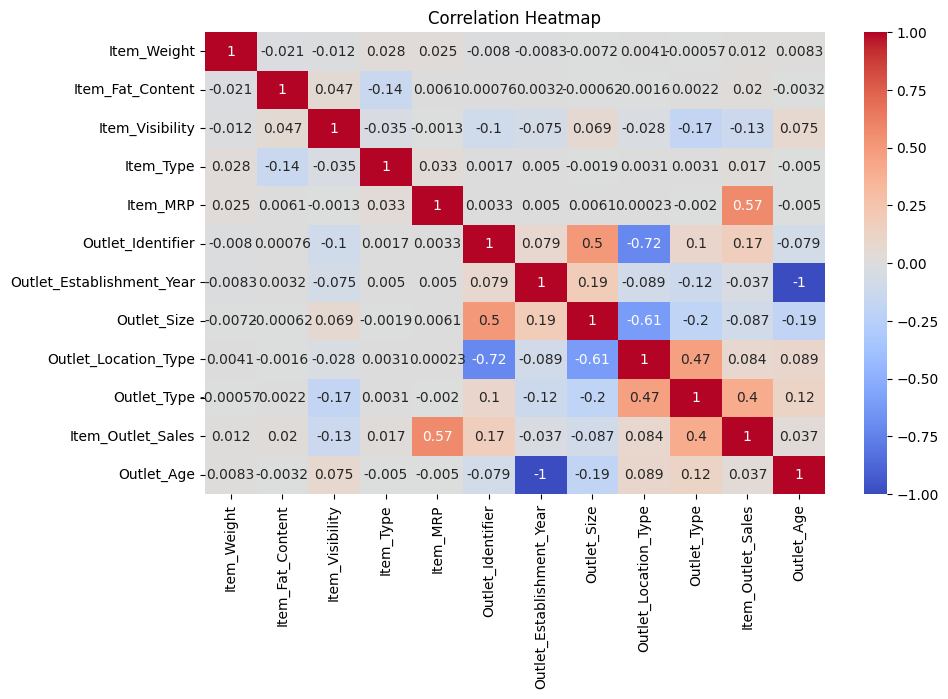

In [ ]:
# Sales distribution
plt.figure(figsize=(6,4))
sns.histplot(train['Item_Outlet_Sales'], bins=50, kde=True)
plt.title("Sales Distribution")
plt.show()

# Item Type vs Sales
plt.figure(figsize=(12,5))
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=train)
plt.xticks(rotation=90)
plt.title("Item Type vs Sales")
plt.show()

# Outlet Type vs Sales
plt.figure(figsize=(8,4))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=train)
plt.title("Outlet Type vs Sales")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
X = train.drop(['Item_Outlet_Sales','Item_Identifier'], axis=1)
y = train['Item_Outlet_Sales']
X_test = test.drop(['Item_Identifier'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor(
    n_estimators=500,      # more trees for better averaging
    max_depth=None,        # let trees grow fully (or tune if overfitting)
    min_samples_split=5,   # avoid splitting too often on small samples
    min_samples_leaf=2,    # avoid leaves with very few samples
    max_features='sqrt',   # reduce correlation between trees
    random_state=42,
    n_jobs=-1              # use all cores for faster training
)

gb = GradientBoostingRegressor(
    n_estimators=1000,    # more boosting rounds
    learning_rate=0.05,   # smaller step for better convergence
    max_depth=3,          # usually shallow trees work better
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,        # stochastic GB to reduce overfitting
    random_state=42
)
# Train
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Validate
rf_pred = rf.predict(X_val)
gb_pred = gb.predict(X_val)

print("RF RMSE:", np.sqrt(mean_squared_error(y_val, rf_pred)))
print("GB RMSE:", np.sqrt(mean_squared_error(y_val, gb_pred)))

RF RMSE: 987.0479465634859
GB RMSE: 995.6964583841941


In [ ]:
rf.fit(X, y)  # train on full train data
gb.fit(X, y)


GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=1000,
                          random_state=42, subsample=0.8)

In [ ]:
rf_test_pred = rf.predict(X_test)
gb_test_pred = gb.predict(X_test)

In [ ]:
# For Random Forest
print("Random Forest Predictions:")
print(rf_test_pred[:10])  # first 10 predictions

# For Gradient Boosting
print("\nGradient Boosting Predictions:")
print(gb_test_pred[:10])


Random Forest Predictions:
[1713.50412637 1340.47245474  661.75187351 2260.98830691 5001.48536163
 2102.70388169  811.60445385 1708.96595865 1303.90768347 2845.34835459]

Gradient Boosting Predictions:
[1474.19318823 1430.1781092   822.04689437 2445.49595747 5344.52613413
 1770.09973234  587.8697694  1697.84409484 1495.3589136  2893.78438095]
